In [1]:
# 2020-1-1

# script to compare the scores for TFBS mapping from fimo across oligo alleles 
# and find cases where there's a difference in binding site prediction

# look for differences across all pairs, but only report as a real difference if qval of at least one of the alleles passes cutoff

# goal cols to add to vars_anno:
# 1 - blank if no differences that pass qval cutoff, the HGNC symbol of TFs that do have diffs that pass the cutoff, "TF1,TF2,TF3" etc.
# 2 - 0 if no differences that pass qval cutoff, the score difference (signed, -ve for derived higher and +ve for ancestral higher) for each TF that does "score1,score2,score3" etc.
# 3 - max score diff (take absolute value to find max, but report here signed)
# 4 - qvals of all ancestral TF motifs for TFs with diff that passed qval cutoff "a-qval1,a-qval2,a-qval3" etc.
# 5 - qvals of all derived TF motifs for TFs with diff that passed qval cutoff "d-qval1,d-qval2,d-qval3" etc.

# 2020-2-6

# finishing up the script so it can be added to vars_anno


# 2020-4-6

# changing score reported so that it reports the signed report
# changing qval to only calculate over mappings over our variant

# 2020-5-4

# adding export of info on "best" mapping (with lowest qval)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pysam
import statsmodels.stats.multitest as smm

In [3]:
#fimo_results = '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/fimo_out_MPRA/fimo.tsv'
fimo_results = '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/fimo_out_trimmed_direct/fimo.tsv'  # trimmed mapping
project_dir = '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS'
human_tfs_filename = '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/Homo_sapiens_2019_12_20_8_14_pm/TF_Information.txt'
our_vars_file = '/Users/cweiss19/Box Sync/MPRA/VARs_anno.xlsx'

In [4]:
var_location = 115
qval_cutoff = 0.05
pval_cutoff = 0.0001

In [5]:
def get_motif_id_clean(f):
    spl = f.split('.')
    motif_id_clean = spl[0]
    return motif_id_clean

def make_tf_motif_id_dict(filename):
    df = pd.read_csv(filename, sep='\t')
    df['motif_id_clean'] = df['Motif_ID'].map(get_motif_id_clean)   # removes ".00"
    df2 = df[df['TF_Status'] == 'D']  # only include TFs with directly measured motifs (no inferred motifs)
    d = dict(zip(df2['motif_id_clean'], df2['TF_Name']))   # {motif_ID1: 'HGNC1'...}  # want 1:1 of motif to TF, a given TF can have multiple motifs (appear with >1 key)
    return d

human_tfs = make_tf_motif_id_dict(human_tfs_filename)   # {motif_ID1: 'HGNC1'}
#print(human_tfs)

In [6]:
def get_oligo(f):
    spl = f.split('_')
    oligo = spl[0] + '_' + spl[1] + '_' + spl[3]
    return oligo

# get only allele source
def get_allele(f):
    spl = f.split('_')
    allele = spl[2]
    return allele

def check_start_stop(g):
    stops = g['stop'].tolist()
    if not all(x == stops[0] for x in stops):
        print('found one')   # make sure all the motifs that start at a given coordinate end at the same coordinate, ran it and they do



In [7]:
# read in TFBS mapping results, each row is a mapping result with oligo and motif
df = pd.read_csv(fimo_results, sep='\t')
df = df.drop(df.tail(3).index)  # there are three random metadata rows at the end

In [8]:
print(df[df['start'].isnull()])

Empty DataFrame
Columns: [motif_id, motif_alt_id, sequence_name, start, stop, strand, score, p-value, q-value, matched_sequence]
Index: []


In [9]:
# add column to easily identify where mapping starts and stops in oligo 
# (sometimes multiple mappings exist between the same oligo and motif)
df['start_stop'] = df['start'].astype(int).astype(str) + '_' + df['stop'].astype(int).astype(str)

# add oligo name without allele source and allele source in separate cols
df['oligo'] = df['sequence_name'].map(get_oligo)
df['allele'] = df['sequence_name'].map(get_allele)

In [10]:
print(df.head(5))
df = df.set_index('oligo')
print(df.head(5))

   motif_id motif_alt_id                                      sequence_name  \
0  M07609_2     M07609_2   libB_seq274422_Derived_[chr22:45554852-45555051]   
1  M07609_2     M07609_2  libB_seq274422_Ancestral_[chr22:45554852-45555...   
2  M07609_2     M07609_2  libB_seq252665_Ancestral_[chr22:45554829-45555...   
3  M07609_2     M07609_2   libB_seq252665_Derived_[chr22:45554829-45555028]   
4  M07625_2     M07625_2    libB_seq306643_Ancestral_[chr2:1156969-1157168]   

   start   stop strand    score       p-value       q-value  \
0  138.0  167.0      -  54.5567  3.520000e-18  2.390000e-12   
1  138.0  167.0      -  54.5567  3.520000e-18  2.390000e-12   
2  161.0  190.0      -  54.5567  3.520000e-18  2.390000e-12   
3  161.0  190.0      -  54.5567  3.520000e-18  2.390000e-12   
4   17.0   46.0      -  52.0000  1.650000e-17  4.310000e-11   

                 matched_sequence start_stop  \
0  ATTGCACCACTGCACTCCAGCCTGGGCGAC    138_167   
1  ATTGCACCACTGCACTCCAGCCTGGGCGAC    138_167   
2 

In [11]:
print(df[(df['motif_id'] == 'M08111_2') & (df.index == 'libA_seq4513_[chr3:11034324-11034523]') & (df['start_stop'] == '20_37')])

                                       motif_id motif_alt_id  \
oligo                                                          
libA_seq4513_[chr3:11034324-11034523]  M08111_2     M08111_2   
libA_seq4513_[chr3:11034324-11034523]  M08111_2     M08111_2   

                                                                         sequence_name  \
oligo                                                                                    
libA_seq4513_[chr3:11034324-11034523]  libA_seq4513_Ancestral_[chr3:11034324-11034523]   
libA_seq4513_[chr3:11034324-11034523]    libA_seq4513_Derived_[chr3:11034324-11034523]   

                                       start  stop strand     score   p-value  \
oligo                                                                           
libA_seq4513_[chr3:11034324-11034523]   20.0  37.0      -  0.618557  0.000005   
libA_seq4513_[chr3:11034324-11034523]   20.0  37.0      - -8.773200  0.000062   

                                       q-value    matched

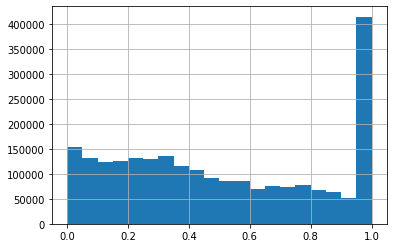

0.0001


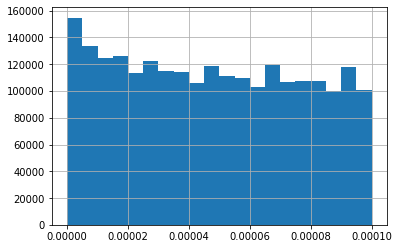

In [12]:
df['q-value'].hist(bins=20)
plt.show()

print(df['p-value'].max())

df['p-value'].hist(bins=20)
plt.show()



In [13]:
## read in vars_anno

df_vars = pd.read_excel(
    our_vars_file, 
    index_col=0, 
    header=2, 
    sheet_name=0,
    usecols=['oligo_ID', 'chromosome']
    )
df_vars.drop(df_vars.index[0], inplace=True)
index_order = df_vars.index.tolist()

## initiate new df with each row an oligo
oligo_df = pd.DataFrame(index=index_order)
oligo_df['oligo'] = index_order
print(oligo_df.head(2))
oligo_df['motifs_with_diffs'] = 0
oligo_df['TFs'] = 0
oligo_df['score_diffs'] = 0
oligo_df['max_score_diff'] = 0
oligo_df['a_qvals'] = 0
oligo_df['d_qvals'] = 0




                                                                       oligo
libB_seq57029_[chr1:1136106-1136305]    libB_seq57029_[chr1:1136106-1136305]
libA_seq229534_[chr1:1197948-1198147]  libA_seq229534_[chr1:1197948-1198147]


In [14]:
## figure out lowest possible mapping score for each motif, 
# to sub in when can't find mapping result for one allele but have result for the other allele
# logic is that if we get mapping for one but not the other, the other had a pval > 1e-04
# look at score for highest (worst) pval available for that motif, score can't be any better than that
# conservative estimate of score diff (it could be a lot bigger)
# make note that this occurred

# create dict of motif to score to sub

motif_score_sub_d = {}
motif_grouped = df.groupby(by='motif_id')
for each_motif, mappings in motif_grouped:
    sorted_mappings = mappings.sort_values(by='score')  # ascending = true, small to big
    lowest_score = sorted_mappings['score'].tolist()[0]  # first item in the list, the lowest score
    motif_score_sub_d[each_motif] = lowest_score



In [15]:
# score diff = derived - ancestral (negative if derived binds worse, positive if derived binds better)
# congruent with logFC (negative means MH downreg, positive means MH upreg)

# takes forever

res = {}

for each_oligo in index_order:
    motifs_passing_qval_with_diff = {}
    
    # check to see if any mappings exist to that oligo
    if not each_oligo in df.index.tolist():
        motifs_passing_qval_with_diff['no_mappings'] = 0 
        res[each_oligo] = motifs_passing_qval_with_diff
        print(each_oligo)
        continue
    
    mappings = df.loc[each_oligo, :]
    mappings_grouped = mappings.groupby(['motif_id', 'start_stop', 'strand'])  # group the mappings by motif and where the motif maps to
    for each_mapping, rows in mappings_grouped:
        motif = rows['motif_id'].tolist()[0]
        strand = rows['strand'].tolist()[0]
        if motif in human_tfs:
            tf = human_tfs[motif]
        if not motif in human_tfs:
            #print('missing motif?', motif)
            continue
        if len(rows) > 2:  # motifs on opposite strands, won't exist now bc grouping with strand included
            print('buh')
            print(rows)
        if len(rows) == 2:
            alleles = rows['allele'].tolist()
            if not 'Ancestral' in alleles:
                print('buh2')
            if not 'Derived' in alleles:
                print('buh3')
            qvals = rows['q-value'].tolist()
            qvals_low_enough = [x for x in qvals if x <= qval_cutoff]
            if len(qvals_low_enough) > 0:  # if one of the mappings had a good enough qval
                score_a = rows.loc[rows['allele'] == 'Ancestral', 'score'].tolist()[0]
                score_d = rows.loc[rows['allele'] == 'Derived', 'score'].tolist()[0]
                qval_a = rows.loc[rows['allele'] == 'Ancestral', 'q-value'].tolist()[0]
                qval_d = rows.loc[rows['allele'] == 'Derived', 'q-value'].tolist()[0]
                score_diff = score_d - score_a
                if score_diff == 0:
                    continue
                motifs_passing_qval_with_diff[each_mapping] = [score_diff, [qval_a, qval_d], 'both']  # both = saw both alleles
        if len(rows) == 1:
            qval = rows['q-value'].values
            if qval <= qval_cutoff:
                lowest = motif_score_sub_d[motif]
                a = rows['allele'].tolist()[0]
                q = rows['q-value'].tolist()[0]
                s = rows['score'].tolist()[0]
                #print(lowest, s)
                if a == 'Ancestral':
                    s_diff = lowest - s  # derived - ancestral
                    if s_diff != 0:
                        motifs_passing_qval_with_diff[each_mapping] = [s_diff, [q, 1], a]
                if a == 'Derived':
                    s_diff = s - lowest
                    if s_diff != 0:
                        motifs_passing_qval_with_diff[each_mapping] = [s_diff, [1, q], a]
                if s_diff == 0:
                    continue
                  # if says 1 allele = subbed in lowest score
        if len(rows) < 1:
            print('buh4')
    
    # unique set of motifs with diffs
    #oligo_df.loc[each_oligo, 'motifs_with_diffs'] = ','.join(list(set([key[0] for key, value in motifs_passing_qval_with_diff.items()])))
    res[each_oligo] = motifs_passing_qval_with_diff
#print(oligo_df.head(10))
#print(res)
    
        
            
    
    

libB_seq267795_[chr5:81687895-81688094]


In [16]:
print(len(res))
print(oligo_df.head(5))
print(res['libA_seq123041_[chr15:67615042-67615241]'])

14042
                                                                       oligo  \
libB_seq57029_[chr1:1136106-1136305]    libB_seq57029_[chr1:1136106-1136305]   
libA_seq229534_[chr1:1197948-1198147]  libA_seq229534_[chr1:1197948-1198147]   
libB_seq264324_[chr1:1203069-1203268]  libB_seq264324_[chr1:1203069-1203268]   
libB_seq75291_[chr1:1500965-1501164]    libB_seq75291_[chr1:1500965-1501164]   
libA_seq35918_[chr1:1839919-1840118]    libA_seq35918_[chr1:1839919-1840118]   

                                       motifs_with_diffs  TFs  score_diffs  \
libB_seq57029_[chr1:1136106-1136305]                   0    0            0   
libA_seq229534_[chr1:1197948-1198147]                  0    0            0   
libB_seq264324_[chr1:1203069-1203268]                  0    0            0   
libB_seq75291_[chr1:1500965-1501164]                   0    0            0   
libA_seq35918_[chr1:1839919-1840118]                   0    0            0   

                                       max_s

In [17]:
m_df_l = []

def parse_out_mapping_info_into_cols(r):
    oligo = r['oligo']
    motif_d = res[oligo]
    
    m_df = pd.DataFrame(columns=['motif', 'start_stop', 'strand', 'tf', 'score_diff', 'qvals', 'oligo', 'which_mapped'], index=motif_d.keys())
    
    for each_motif, score_info in motif_d.items():
        if each_motif == 'no_mappings':
            print(each_motif, oligo)
            m_df.loc['no_mappings', ['motif', 'start_stop', 'strand', 'tf', 'score_diff', 'qvals', 'oligo', 'which_mapped']] = ['no_mappings', 0, 0, 0, 0, [0], oligo, 0] 
            continue
        motif = each_motif[0]
        start_stop = each_motif[1]
        strand = each_motif[2]
        tf = human_tfs[motif]
        score_diff = score_info[0]  
        qvals = score_info[1]  # list of two items [aqval, dqval]
        allele_info = score_info[2]
        
        m_df.loc[each_motif, ['motif', 'start_stop', 'strand', 'tf', 'score_diff', 'qvals', 'oligo', 'which_mapped']] = [motif, start_stop, strand, tf, score_diff, qvals, oligo, allele_info]
    #print(m_df)
    m_df_l.append(m_df)
    return r


oligo_df = oligo_df.apply(lambda row: parse_out_mapping_info_into_cols(row), axis=1)

tfbs_diff_df = pd.concat(m_df_l)


no_mappings libB_seq267795_[chr5:81687895-81688094]


In [18]:
print(tfbs_diff_df.head(5))
tfbs_diff_df.to_csv(
    '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/fimo_trimmed_direct_diffs.txt', 
    sep='\t', 
    index=False
    #index_label=['motif', 'start_stop', 'strand']
)

                         motif start_stop strand      tf score_diff  \
(M07610_2, 19_42, +)  M07610_2      19_42      +   PRDM9   -1.23365   
(M07843_2, 15_35, +)  M07843_2      15_35      +  ZNF263    4.04122   
(M08260_2, 15_35, +)  M08260_2      15_35      +  ZNF467    1.05102   
(M08260_2, 29_49, +)  M08260_2      29_49      +  ZNF467   -0.15306   
(M08864_2, 28_49, +)  M08864_2      28_49      +   PATZ1   -1.35213   

                                 qvals                                 oligo  \
(M07610_2, 19_42, +)  [0.0348, 0.0447]  libB_seq57029_[chr1:1136106-1136305]   
(M07843_2, 15_35, +)       [1, 0.0414]  libB_seq57029_[chr1:1136106-1136305]   
(M08260_2, 15_35, +)       [1, 0.0301]  libB_seq57029_[chr1:1136106-1136305]   
(M08260_2, 29_49, +)       [0.0366, 1]  libB_seq57029_[chr1:1136106-1136305]   
(M08864_2, 28_49, +)       [0.0351, 1]  libB_seq57029_[chr1:1136106-1136305]   

                     which_mapped  
(M07610_2, 19_42, +)         both  
(M07843_2, 15_35, +)

In [19]:
print(len(tfbs_diff_df[tfbs_diff_df['which_mapped'] == 'both']))
print(len(tfbs_diff_df))
tfbs_diff_df['abs_score_diff'] = tfbs_diff_df['score_diff'].abs()
print(tfbs_diff_df.head(5))

print(tfbs_diff_df[tfbs_diff_df['score_diff'] == 0])
tfbs_diff_df.to_csv(
    '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/fimo_trimmed_direct_diffs.txt', 
    sep='\t', 
    index=False
    #index_label=['motif', 'start_stop', 'strand']
)

28858
46471
                         motif start_stop strand      tf score_diff  \
(M07610_2, 19_42, +)  M07610_2      19_42      +   PRDM9   -1.23365   
(M07843_2, 15_35, +)  M07843_2      15_35      +  ZNF263    4.04122   
(M08260_2, 15_35, +)  M08260_2      15_35      +  ZNF467    1.05102   
(M08260_2, 29_49, +)  M08260_2      29_49      +  ZNF467   -0.15306   
(M08864_2, 28_49, +)  M08864_2      28_49      +   PATZ1   -1.35213   

                                 qvals                                 oligo  \
(M07610_2, 19_42, +)  [0.0348, 0.0447]  libB_seq57029_[chr1:1136106-1136305]   
(M07843_2, 15_35, +)       [1, 0.0414]  libB_seq57029_[chr1:1136106-1136305]   
(M08260_2, 15_35, +)       [1, 0.0301]  libB_seq57029_[chr1:1136106-1136305]   
(M08260_2, 29_49, +)       [0.0366, 1]  libB_seq57029_[chr1:1136106-1136305]   
(M08864_2, 28_49, +)       [0.0351, 1]  libB_seq57029_[chr1:1136106-1136305]   

                     which_mapped abs_score_diff  
(M07610_2, 19_42, +)         

In [20]:
#print(tfbs_diff_df[(tfbs_diff_df['oligo'] == 'libA_seq123041_[chr15:67615042-67615241]') & (tfbs_diff_df['tf'] == 'FLI1')])
print(tfbs_diff_df[tfbs_diff_df['oligo'] == 'libA_seq123041_[chr15:67615042-67615241]'])




                         motif start_stop strand      tf score_diff  \
(M04509_2, 23_34, +)  M04509_2      23_34      +  ZNF281    -5.1753   
(M04529_2, 19_34, +)  M04529_2      19_34      +  ZNF444   -9.19587   
(M04530_2, 19_34, +)  M04530_2      19_34      +  ZNF444   -7.49485   
(M08321_2, 22_33, +)  M08321_2      22_33      +  ZNF281     -9.268   
(M08878_2, 21_39, +)  M08878_2      21_39      +  ZBTB17    -4.4129   
(M08906_2, 23_37, +)  M08906_2      23_37      +  ZNF281    -7.3608   

                                 qvals  \
(M04509_2, 23_34, +)   [0.0465, 0.094]   
(M04529_2, 19_34, +)  [0.0385, 0.0823]   
(M04530_2, 19_34, +)  [0.0437, 0.0815]   
(M08321_2, 22_33, +)  [0.0243, 0.0867]   
(M08878_2, 21_39, +)   [0.0172, 0.057]   
(M08906_2, 23_37, +)  [0.0146, 0.0562]   

                                                         oligo which_mapped  \
(M04509_2, 23_34, +)  libA_seq123041_[chr15:67615042-67615241]         both   
(M04529_2, 19_34, +)  libA_seq123041_[chr15:67615

In [ ]:
#print(oligo_df.head(5))
if 'motifs_with_diffs' in oligo_df.columns:
    oligo_df = oligo_df.drop('motifs_with_diffs', axis=1)
if 'max_score_diff' in oligo_df.columns:
    oligo_df = oligo_df.drop('max_score_diff', axis=1)
print(oligo_df.head(5))


oligo_df['biggest_diff_TF'] = 0
oligo_df['biggest_diff_score_diff'] = 0
oligo_df['biggest_diff_which_mapped'] = 0
oligo_df['biggest_diff_TF_aqval'] = 0
oligo_df['biggest_diff_TF_dqval'] = 0
oligo_df['which_mapped'] = 0


oligo_df['best_mapping_TF'] = 0
oligo_df['best_mapping_score_diff'] = 0
oligo_df['best_mapping_which_mapped'] = 0
oligo_df['best_mapping_TF_aqval'] = 0
oligo_df['best_mapping_TF_dqval'] = 0




In [ ]:
# iterate over all diffs per oligo and summarize into vars_anno

def find_lowest_qval(mpgs):
    lowest = 1
    lowest_mpg = None
    qvals = mpgs['qvals'].tolist()
    idx_l = mpgs.index.tolist()
    for each_qvals in qvals:
        idx = qvals.index(each_qvals)
        if len(each_qvals) == 2:
            aq = each_qvals[0]
            dq = each_qvals[1]
        if len(each_qvals) < 2:
            continue
        if aq < lowest:
            lowest = aq
            lowest_mpg = idx_l[idx]
        if dq < lowest:
            lowest = dq
            lowest_mpg = idx_l[idx]
    #print(lowest_mpg)
    return lowest_mpg
            

diffs_grouped = tfbs_diff_df.groupby('oligo')
for each_oligo, diffs in diffs_grouped:
    TFs_with_diffs = []
    diff_scores = []
    allele_mapping = []
    a_qvals = []
    d_qvals = []
    tf_grouped = diffs.groupby('tf')
    for each_tf, tf_diffs in tf_grouped:
        biggest_diff = tf_diffs[tf_diffs['abs_score_diff'] == tf_diffs['abs_score_diff'].max()]  # FOR THIS TF
        if not len(biggest_diff) == 1:
            biggest_diff = biggest_diff.iloc[0].to_frame().transpose()
            #print(biggest_diff)
        TFs_with_diffs.append(biggest_diff['tf'].values[0])
        diff_scores.append(biggest_diff['score_diff'].values[0])
        allele_mapping.append(biggest_diff['which_mapped'].values[0])
        qvals_list = biggest_diff['qvals'].values[0]
        #print(qvals_list)
        a_qvals.append(qvals_list[0])
        if len(qvals_list) == 2:
            d_qvals.append(qvals_list[1])
        else:
            d_qvals.append('0')
    diff_scores = [float(x) for x in diff_scores]
    
    biggest_tf_diff = max(diff_scores, key=abs)
    idx = diff_scores.index(biggest_tf_diff)
    biggest_tf = TFs_with_diffs[idx]
    biggest_tf_a_qval = a_qvals[idx]
    biggest_tf_d_qval = d_qvals[idx]
    biggest_tf_mapping = allele_mapping[idx]
    
    #print(biggest_tf)
    
    diff_scores = [str(x) for x in diff_scores]
    a_qvals = [str(x) for x in a_qvals]
    d_qvals = [str(x) for x in d_qvals]
    
    oligo_df.loc[each_oligo, 'TFs'] = ','.join([str(x) for x in TFs_with_diffs])
    oligo_df.loc[each_oligo, 'score_diffs'] = ','.join(diff_scores)
    oligo_df.loc[each_oligo, 'which_mapped'] = ','.join([str(x) for x in allele_mapping])
    oligo_df.loc[each_oligo, 'a_qvals'] = ','.join([str(x) for x in a_qvals])
    oligo_df.loc[each_oligo, 'd_qvals'] = ','.join([str(x) for x in d_qvals])
    
    oligo_df.loc[each_oligo, 'biggest_diff_TF'] = biggest_tf
    oligo_df.loc[each_oligo, 'biggest_diff_score_diff'] = biggest_tf_diff
    oligo_df.loc[each_oligo, 'biggest_diff_which_mapped'] = biggest_tf_mapping
    oligo_df.loc[each_oligo, 'biggest_diff_TF_aqval'] = biggest_tf_a_qval
    oligo_df.loc[each_oligo, 'biggest_diff_TF_dqval'] = biggest_tf_d_qval
    
    # best mapping tf = the tf with the lowest qval in either a or d, and it's score diff
    #print(diffs)
    lowest_mapping = find_lowest_qval(diffs)
    #print(lowest_mapping)
    
    if lowest_mapping == None:
        continue
    
    #print(diffs.index)
    #print(diffs)
    #print(type(diffs))
        
    l_m_score_diff = diffs.loc[[lowest_mapping], 'score_diff'].values[0]
    l_m_tf = diffs.loc[[lowest_mapping], 'tf'].values[0]
    l_m_which_mapped = diffs.loc[[lowest_mapping], 'which_mapped'].values[0]
    l_m_qvals = diffs.loc[[lowest_mapping], 'qvals'].values[0]
    l_m_aq = l_m_qvals[0]
    if len(l_m_qvals) == 2:
        l_m_dq = l_m_qvals[1]
    else:
        l_m_dq = 1
    
    #print(l_m_qvals)
    
    
    oligo_df.loc[each_oligo, 'best_mapping_TF'] = l_m_tf
    oligo_df.loc[each_oligo, 'best_mapping_score_diff'] = l_m_score_diff
    oligo_df.loc[each_oligo, 'best_mapping_which_mapped'] = l_m_which_mapped
    oligo_df.loc[each_oligo, 'best_mapping_TF_aqval'] = l_m_aq
    oligo_df.loc[each_oligo, 'best_mapping_TF_dqval'] = l_m_dq
    
    

print(oligo_df.head(5))
        
        

In [ ]:
print(oligo_df.head(2))
print(len(oligo_df[oligo_df['biggest_diff_which_mapped'] == 'both']))
print(oligo_df['biggest_diff_which_mapped'].value_counts())

In [ ]:
oligo_df.to_csv(
    '/Users/cweiss19/Box Sync/MPRA/DATA/databases_for_overlap/TFBS/oligo_tfbs_differences.txt',
    sep='\t',
    index=False)